In [1]:
# Implementation use Tensorflow 2
import time
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam, SGD
import random
import numpy as np
from keras import backend as K
import time
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.test.is_built_with_cuda())

Num GPUs Available:  1
True


In [2]:
# data for create Toy Example of Paper
def createData(B, epsilons, sigmas, T=2, samples=10000):
    X = np.random.uniform(0, 1, size=(samples, 250)).astype(np.float32)
    ys = []
    for i in range(samples):
        x = X[i]
        y = []
        for j in range(T):
            y.append(sigmas[j]*np.tanh((B + epsilons[j]).dot(x)))
        ys.append(y)
    return X, np.array(ys)     

# Toy example model
def toyExample(input_dim=250, layers=4, neurons=100, activation='relu', Tasks=2):
    x = Input(shape = (input_dim, ))
    shared = Dense(neurons)(x)
    for i in range(layers-1):
        if i == layers - 2:
            shared = Dense(neurons, activation=activation, name='last_shared_layer')(shared)
        else:
            shared = Dense(neurons, activation=activation)(shared)
    outputs = []
    for i in range(Tasks):
        outputs.append(Dense(100, activation='linear', name=f'task-{i}')(shared))
    
    model = Model(inputs= x, outputs = outputs)
    # model.compile(loss='mse', optimizer=SGD(lr=0.001), metrics=['accuracy'])
    return model

In [3]:
# Set seed for create synthetic data

seed = 40
random.seed(seed)
Tasks = 2

B = np.random.normal(scale=10, size=(100, 250)).astype(np.float32)
epsilons = np.random.normal(scale=3.5, size=(Tasks, 100, 250)).astype(np.float32)
sigmas = [1.0, 100.0]

X, Y = createData(B, epsilons, sigmas, T = Tasks)
print('X shape: ', X.shape)
print('Y shape', Y.shape)
model = toyExample()
model.summary()

X shape:  (10000, 250)
Y shape (10000, 2, 100)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 250)]        0           []                               
                                                                                                  
 dense (Dense)                  (None, 100)          25100       ['input_1[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 100)          10100       ['dense[0][0]']                  
                                                                                                  
 dense_2 (Dense)                (None, 100)          10100       ['dense_1[0][0]']                
                                               

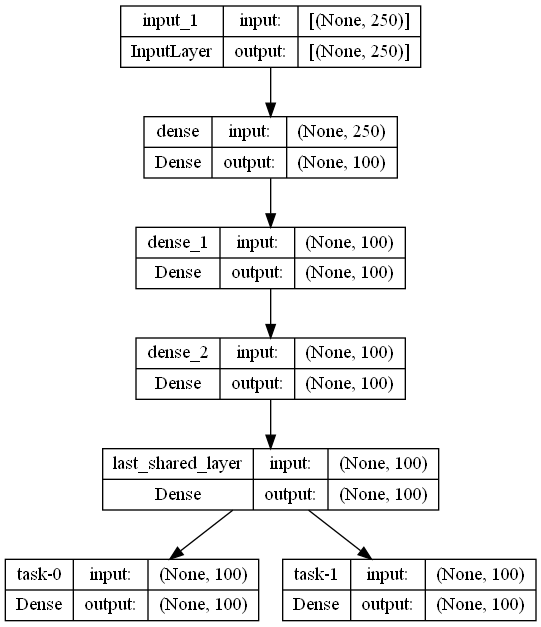

In [4]:
plot_model(model, show_shapes=True)

### Train toy example dont balancing weights

In [5]:
model_classic = toyExample()
model_classic.compile(loss='mse', 
                    loss_weights=[1.0, 1.0], #weights of tasks 1.0 , 1.0 
                    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3))
h = model_classic.fit(X, [Y[:, 0, :], Y[:, 1, :]],
                            validation_split = 0.2,
                            epochs=500,
                            batch_size=128,
                            verbose=False)


2
[<AxesSubplot:> <AxesSubplot:>]
0
1


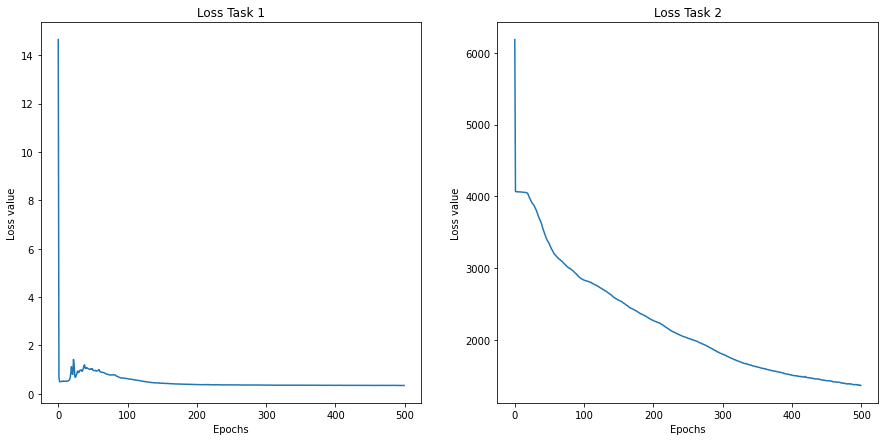

In [30]:
import matplotlib.pyplot as plt

def plotArange(rows, columns, data, xlabels, ylabels, titles, figsize=(15, 7)):
    fig, axs = plt.subplots(nrows=rows, ncols=columns,
                            figsize=figsize,
                            constrained_layout=False)
    print(len(axs))
    count = 0
    # for ax in axs:
    #     print(count)
    #     ax.plot(data[count])
    #     ax.set_xlabel(xlabels)
    #     ax.set_ylabel(ylabels)
    #     ax.set_title(titles[count])
    #     count += 1
    print(axs)
    for row in range(rows):
        for col in range(columns):
            print(count)
            axs[count].plot(data[count])
            axs[count].set_xlabel(xlabels)
            axs[count].set_ylabel(ylabels)
            axs[count].set_title(titles[count])
            count += 1
    return fig

def multiplePlot(data, xlabels, ylabels, legends, figsize=(15, 7)):
    fig, ax = plt.subplots(figsize=figsize)
    n = len(data)
    i = 0
    for d in data:
        ax.plot(d, label=legends[i])
        ax.set_xlabel(xlabels)
        ax.set_ylabel(ylabels)
        ax.legend()
        i+=1
    return fig
        


losses = [h.history['task-0_loss'], h.history['task-1_loss']]
titles = ['Loss Task 1', 'Loss Task 2']
xlabels = 'Epochs'
ylabels = 'Loss value'
fig = plotArange(1, 2, losses, xlabels, ylabels, titles)

## GradNorm Implementation

In [6]:
'''
Parameters:
* model: keras model to train
* X_train, Y_train: input and output to train
* n_tasks: Number of tasks of model
* weights: Inital weights of tasks
* losses: losses objects to each task
* metrics: metrics to evaluate per task
* alpha: hyper parameter of gradNorm algorithm
* verbose: print status of trainig
'''
@tf.function
def training_on_batch(model, x_batch_train, y_batch_train, n_tasks,
                    alpha, epoch, gradNorm):
    
    with tf.GradientTape(persistent=True) as tape:
        # Forward pass
        y_pred = model(x_batch_train, training=True)
        # Task losses evaluation
        losses_value = []
        weighted_losses = []
        total_loss = 0.0    #tf.Variable(0.0, trainable=False)
        for i in range(n_tasks):
            
            Li = (losses[i])(y_true=y_batch_train[:,i], y_pred=y_pred[i])
            losses_value.append(Li)
            # weighted Losses
            w_Li = tf.multiply(ws[i], Li)
            weighted_losses.append(w_Li)
            # add total loss
            total_loss = tf.add(total_loss, w_Li)
            
        if gradNorm == True:
            # L0: initial task losses
            if epoch == 0:
                for i in range(n_tasks):
                    L0_s[i].assign(losses_value[i])
            
            # Gi_W
            last_shared_layer = model.get_layer('last_shared_layer')
            Gi_norms = []
            for i in range(n_tasks):
                wLi = weighted_losses[i]
                Gi_W = tape.gradient(wLi, last_shared_layer.trainable_variables)[0]
                # Gradient norms
                Gi_norm = tf.norm(Gi_W, ord=2)
                Gi_norms.append(Gi_norm)
            
            # Average of task gradients
            G_avg = 0.0 # tf.Variable(0.0, trainable=False)
            for i in range(n_tasks):
                G_avg = tf.add(G_avg, Gi_norms[i])
            G_avg = tf.divide(G_avg, float(n_tasks))
            
            # Relative Losses
            lhat = []
            lhat_avg = 0.0 #tf.Variable(0.0, trainable=False)
            for i in range(n_tasks):
                lhat_i = tf.divide(losses_value[i], L0_s[i])
                lhat.append(lhat_i)
                lhat_avg = tf.add(lhat_avg, lhat_i)
            lhat_avg = tf.divide(lhat_avg, float(n_tasks))
            
            # Relative inverse training rates
            inv_rates = []
            for i in range(n_tasks):
                inv_rate = tf.divide(lhat[i], lhat_avg)
                inv_rates.append(inv_rate)
            
            #  Calculating the constant target for Eq. 2 in the GradNorm paper
            a  = tf.constant(alpha)
            C = []    
            for i in range(n_tasks):
                Ci = tf.multiply(G_avg, tf.pow(inv_rates[i], a))
                Ci = tf.stop_gradient(tf.identity(Ci))
                C.append(Ci)

            L_gradnorm = 0.0 #tf.Variable(0.0, trainable=False)
            for i in range(n_tasks):
                L_gradnorm = tf.add(L_gradnorm, tf.abs(tf.subtract(Gi_norms[i], C[i])))


    # Compute standard gradients
    grads = tape.gradient(total_loss, model.trainable_variables)
    
    # Model step optimization
    optimizer_model.apply_gradients(zip(grads, model.trainable_variables))
    
    if gradNorm == True:
        # Weights step optimization
        gradsw = tape.gradient(L_gradnorm, ws)
        optimizer_weights.apply_gradients(zip(gradsw, ws))
        # loss_step = optimizer_weights.minimize(L_gradnorm, ws, tape=tape)
    return losses_value
    
    
def GradNorm(model, X_train, Y_train, n_tasks, weights, losses, metrics_p, 
             epochs = 10, batch_size=64, LR=1e-4, alpha=0.12, gradNorm=True, verbose=False):
    global losses_values
    global weights_values
    global metrics
    global ws
    global L0_s
    global optimizer_model
    global optimizer_weights
    # global losses_value
    # losses_value = []
    
    losses_values = [ [] for _ in range(n_tasks) ]
    weights_values = [ [] for _ in range(n_tasks) ]
    metrics = metrics_p
    

    lobj = tf.keras.losses.MeanSquaredError()

    if (len(weights) != n_tasks) or (len(losses) != n_tasks):
        raise Exception('Number of losses and weights need to be equal of tasks number')
    ws = []     # Task weights
    L0_s = []   # Initial Losses
    for i in range(n_tasks):
        ws.append(tf.Variable(1.0, trainable=True, constraint=tf.keras.constraints.NonNeg()))
        L0_s.append(tf.Variable(-1.0, trainable=False))
    print(ws)
    
    # Optimizers
    optimizer_model   = tf.keras.optimizers.Adam(learning_rate=LR)
    optimizer_weights = tf.keras.optimizers.Adam(learning_rate=LR*1e-3)
    
    # Dataset
    # np.random.shuffle(X_train)
    # np.random.shuffle(Y_train)
    d = tf.data.Dataset.from_tensor_slices((X_train, Y_train))

    train_dataset = d.shuffle(buffer_size = 1024, reshuffle_each_iteration=True).batch(batch_size) #, drop_remainder=True)
    
    for epoch in range(epochs):
        print(f'Start epoch {epoch}')
        # Metrics
        for m in metrics:
            m.reset_state()
        
        for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
            # Standard forward pass
        
        #     with tf.GradientTape(persistent=True) as tape:
        #         # Forward pass
        #         y_pred = model(x_batch_train, training=True)
        #         # Task losses evaluation
        #         losses_value = []
        #         weighted_losses = []
        #         total_loss = 0.0    #tf.Variable(0.0, trainable=False)
        #         for i in range(n_tasks):
                    
        #             Li = (losses[i])(y_true=y_batch_train[:,i], y_pred=y_pred[i])
        #             losses_value.append(Li)
        #             # weighted Losses
        #             w_Li = tf.multiply(ws[i], Li)
        #             weighted_losses.append(w_Li)
        #             # add total loss
        #             total_loss = tf.add(total_loss, w_Li)
                    
        #         if gradNorm == True:
        #             # L0: initial task losses
        #             if epoch == 0:
        #                 for i in range(n_tasks):
        #                     L0_s[i].assign(losses_value[i])
                    
        #             # Gi_W
        #             last_shared_layer = model.get_layer('last_shared_layer')
        #             Gi_norms = []
        #             for i in range(n_tasks):
        #                 wLi = weighted_losses[i]
        #                 Gi_W = tape.gradient(wLi, last_shared_layer.trainable_variables)[0]
        #                 # Gradient norms
        #                 Gi_norm = tf.norm(Gi_W, ord=2)
        #                 Gi_norms.append(Gi_norm)
                    
        #             # Average of task gradients
        #             G_avg = 0.0 # tf.Variable(0.0, trainable=False)
        #             for i in range(n_tasks):
        #                 G_avg = tf.add(G_avg, Gi_norms[i])
        #             G_avg = tf.divide(G_avg, float(n_tasks))
                    
        #             # Relative Losses
        #             lhat = []
        #             lhat_avg = 0.0 #tf.Variable(0.0, trainable=False)
        #             for i in range(n_tasks):
        #                 lhat_i = tf.divide(losses_value[i], L0_s[i])
        #                 lhat.append(lhat_i)
        #                 lhat_avg = tf.add(lhat_avg, lhat_i)
        #             lhat_avg = tf.divide(lhat_avg, float(n_tasks))
                    
        #             # Relative inverse training rates
        #             inv_rates = []
        #             for i in range(n_tasks):
        #                 inv_rate = tf.divide(lhat[i], lhat_avg)
        #                 inv_rates.append(inv_rate)
                    
        #             #  Calculating the constant target for Eq. 2 in the GradNorm paper
        #             a  = tf.constant(alpha)
        #             C = []    
        #             for i in range(n_tasks):
        #                 Ci = tf.multiply(G_avg, tf.pow(inv_rates[i], a))
        #                 Ci = tf.stop_gradient(tf.identity(Ci))
        #                 C.append(Ci)

        #             L_gradnorm = 0.0 #tf.Variable(0.0, trainable=False)
        #             for i in range(n_tasks):
        #                 L_gradnorm = tf.add(L_gradnorm, tf.abs(tf.subtract(Gi_norms[i], C[i])))


        #     # Compute standard gradients
        #     grads = tape.gradient(total_loss, model.trainable_variables)
            
        #     # Model step optimization
        #     optimizer_model.apply_gradients(zip(grads, model.trainable_variables))
            
        #     if gradNorm == True:
        #         # Weights step optimization
        #         gradsw = tape.gradient(L_gradnorm, ws)
        #         optimizer_weights.apply_gradients(zip(gradsw, ws))
        #         # loss_step = optimizer_weights.minimize(L_gradnorm, ws, tape=tape)
                
        #     # Track progress
        #     for i in range(n_tasks):
        #         metrics[i].update_state(losses_value[i])
        #         losses_values[i].append(losses_value[i].numpy())
       
        # # Renormalizing the losses weights
        # coef = 0.0
        # for i in range(n_tasks):
        #     coef += ws[i]
        # coef = tf.divide(float(n_tasks), coef)
        
        # for i in range(n_tasks):
        #     ws[i].assign(tf.multiply(coef, ws[i]))
        #     weights_values[i].append(ws[i].numpy())

            losses_value = training_on_batch(model, x_batch_train, y_batch_train, n_tasks,
                    alpha, epoch, gradNorm)
            # Track progress
            for i in range(n_tasks):
                metrics[i].update_state(losses_value[i])
                losses_values[i].append(losses_value[i].numpy())
        # Renormalizing the losses weights
        coef = 0.0
        for i in range(n_tasks):
            coef += ws[i]
        coef = tf.divide(float(n_tasks), coef)
        
        for i in range(n_tasks):
            ws[i].assign(tf.multiply(coef, ws[i]))
            weights_values[i].append(ws[i].numpy())
        # Tracking progress
        if (verbose):
            print("Epoch {:5d}:".format(epoch), end=' -> ')
            for i in range(n_tasks):
                print("Loss task{:02d}: {:.3f}".format(i, metrics[i].result().numpy()), end=", ")
                print("w{:02d}: {:.6f}".format(i, ws[i].numpy()), end=" ")
            print("\n", end="")

    return losses_values, weights_values

### Toy Example With 2 Tasks

In [8]:
losses = [tf.keras.losses.MeanSquaredError(),
          tf.keras.losses.MeanSquaredError()]
metrics = [tf.keras.metrics.Mean(),
           tf.keras.metrics.Mean()]
weights = [1.0, 1.0]
# model = toyExample()
tf.keras.backend.clear_session()
model=toyExample()

Ls, Ws = GradNorm(model, X, Y, 2, weights, losses, metrics, LR=1e-3,epochs=500, verbose=False)
# l1, l2, w1, w2


[<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=1.0>, <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=1.0>]
Start epoch 0


ValueError: in user code:

    File "C:\Users\jpcas\AppData\Local\Temp\ipykernel_6520\1704239028.py", line 87, in training_on_batch  *
        optimizer_model.apply_gradients(zip(grads, model.trainable_variables))
    File "c:\Users\jpcas\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 646, in apply_gradients  **
        self._create_all_weights(var_list)
    File "c:\Users\jpcas\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 858, in _create_all_weights
        _ = self.iterations
    File "c:\Users\jpcas\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 866, in __getattribute__
        return super(OptimizerV2, self).__getattribute__(name)
    File "c:\Users\jpcas\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 1033, in iterations
        self._iterations = self.add_weight(
    File "c:\Users\jpcas\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 1233, in add_weight
        variable = self._add_variable_with_custom_getter(
    File "c:\Users\jpcas\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\base_layer_utils.py", line 126, in make_variable
        return tf.compat.v1.Variable(

    ValueError: tf.function only supports singleton tf.Variables created on the first call. Make sure the tf.Variable is only created once or created outside tf.function. See https://www.tensorflow.org/guide/function#creating_tfvariables for more information.


2
[<AxesSubplot:> <AxesSubplot:>]
0
1


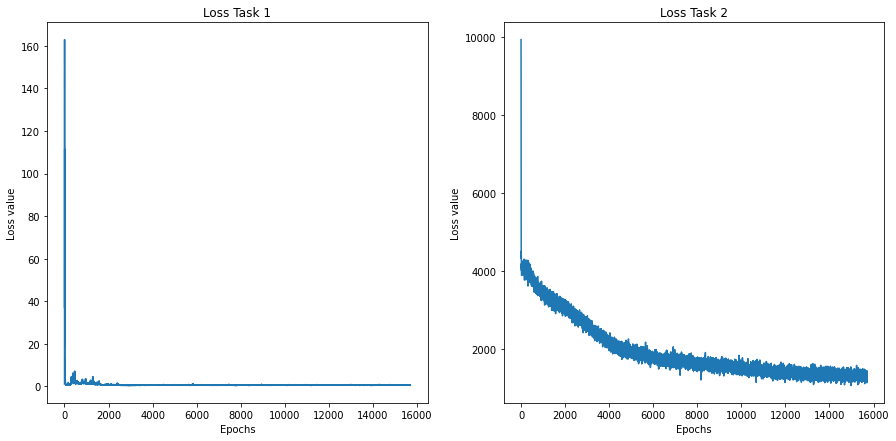

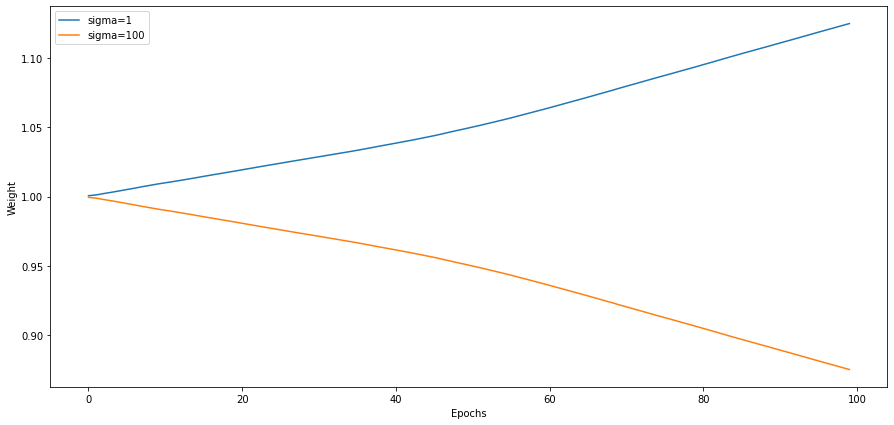

In [47]:
losses = [Ls[0], Ls[1]]
titles = ['Loss Task 1', 'Loss Task 2']
xlabels = 'Epochs'
ylabels_l = 'Loss value'
ylabels_w = 'Weight'
legends = ['sigma=1', 'sigma=100']

fig_loss = plotArange(1, 2, losses, xlabels, ylabels_l, titles)
fig_w = multiplePlot(Ws, xlabels, ylabels_w, legends)

### Toy Example with 10 Tasks

In [49]:
sigmas_10 = [48.0, 3.0, 54.0, 16.0, 9.0, 30.0, 52.0, 26.0, 47.0, 81.0]
B = np.random.normal(scale=10, size=(100, 250)).astype(np.float32)
epsilons_10 = np.random.normal(scale=3.5, size=(10, 100, 250)).astype(np.float32)
X_10, Y_10 = createData(B, epsilons_10, sigmas_10, T=10)
print('X_10 shape: ', X_10.shape)
print('Y_10 shape: ', Y_10.shape)
# losses_10 = [tf.keras.losses.MeanSquaredError() for i in range(10)]
losses = [tf.keras.losses.MeanSquaredError(),tf.keras.losses.MeanSquaredError(), tf.keras.losses.MeanSquaredError(),tf.keras.losses.MeanSquaredError(),tf.keras.losses.MeanSquaredError(),tf.keras.losses.MeanSquaredError(),tf.keras.losses.MeanSquaredError(),tf.keras.losses.MeanSquaredError(),tf.keras.losses.MeanSquaredError(),tf.keras.losses.MeanSquaredError()]
metrics = [tf.keras.metrics.Mean() for i in range(10)]
weights = [1.0 for i in range(10)]

tf.keras.backend.clear_session()
model=toyExample(Tasks=10)

Ls_10, Ws_10 = GradNorm(model, X_10, Y_10, 10, weights, losses, metrics, LR=1e-2, epochs=100, verbose=False)

X_10 shape:  (10000, 250)
Y_10 shape:  (10000, 10, 100)
[<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=1.0>, <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=1.0>, <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=1.0>, <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=1.0>, <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=1.0>, <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=1.0>, <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=1.0>, <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=1.0>, <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=1.0>, <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=1.0>]
Start epoch 0


ValueError: in user code:

    File "C:\Users\jpcas\AppData\Local\Temp\ipykernel_7252\3847064306.py", line 87, in training_on_batch  *
        optimizer_model.apply_gradients(zip(grads, model.trainable_variables))
    File "c:\Users\jpcas\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 646, in apply_gradients  **
        self._create_all_weights(var_list)
    File "c:\Users\jpcas\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 858, in _create_all_weights
        _ = self.iterations
    File "c:\Users\jpcas\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 866, in __getattribute__
        return super(OptimizerV2, self).__getattribute__(name)
    File "c:\Users\jpcas\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 1033, in iterations
        self._iterations = self.add_weight(
    File "c:\Users\jpcas\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 1233, in add_weight
        variable = self._add_variable_with_custom_getter(
    File "c:\Users\jpcas\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\base_layer_utils.py", line 126, in make_variable
        return tf.compat.v1.Variable(

    ValueError: tf.function only supports singleton tf.Variables created on the first call. Make sure the tf.Variable is only created once or created outside tf.function. See https://www.tensorflow.org/guide/function#creating_tfvariables for more information.
